In [1]:
import xarray as xr
import numpy as np
import gdal

In [2]:
ds = xr.open_dataset("D:\\EOData\\DCS4COP\\S2Plus\\DCS4COP_S2A_0021_FLANDERS_20180802T105621Z_31UCS_V003.nc")

In [3]:
ds

<xarray.Dataset>
Dimensions:                       (x: 10980, y: 10980)
Coordinates:
  * x                             (x) float64 3e+05 3e+05 ... 4.098e+05
  * y                             (y) float64 5.7e+06 5.7e+06 ... 5.59e+06
    lon                           (y, x) float32 ...
    lat                           (y, x) float32 ...
Data variables:
    transverse_mercator           int32 ...
    rrs_443                       (y, x) float32 ...
    rrs_490                       (y, x) float32 ...
    rrs_560                       (y, x) float32 ...
    rrs_665                       (y, x) float32 ...
    rrs_705                       (y, x) float32 ...
    rrs_740                       (y, x) float32 ...
    rrs_783                       (y, x) float32 ...
    rrs_842                       (y, x) float32 ...
    rrs_865                       (y, x) float32 ...
    rrs_1610                      (y, x) float32 ...
    rrs_2190                      (y, x) float32 ...
    TUR_NECHAD2009_

In [4]:
ds.x

<xarray.DataArray 'x' (x: 10980)>
array([300005., 300015., 300025., ..., 409775., 409785., 409795.])
Coordinates:
  * x        (x) float64 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05 4.098e+05
Attributes:
    units:          m
    standard_name:  projection_x_coordinate

In [5]:
ds.rrs_443

<xarray.DataArray 'rrs_443' (y: 10980, x: 10980)>
[120560400 values with dtype=float32]
Coordinates:
  * x        (x) float64 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05 4.098e+05
  * y        (y) float64 5.7e+06 5.7e+06 5.7e+06 ... 5.59e+06 5.59e+06 5.59e+06
    lon      (y, x) float32 ...
    lat      (y, x) float32 ...
Attributes:
    standard_name:  surface_ratio_of_upwelling_radiance_emerging_from_sea_wat...
    long_name:      sea surface reflectance defined as the ration of water-le...
    units:          sr-1
    grid_mapping:   transverse_mercator

In [6]:
ds.rrs_443.encoding

{'zlib': True,
 'shuffle': True,
 'complevel': 4,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (1373, 1373),
 'source': 'D:\\EOData\\DCS4COP\\S2Plus\\DCS4COP_S2A_0021_FLANDERS_20180802T105621Z_31UCS_V003.nc',
 'original_shape': (10980, 10980),
 'dtype': dtype('int16'),
 '_FillValue': 32767,
 'scale_factor': 0.001,
 'add_offset': 32.768,
 'coordinates': 'lat lon'}

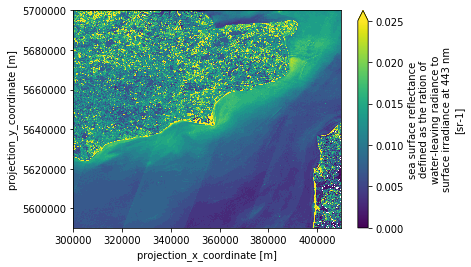

In [39]:
ds.rrs_443.plot.imshow(vmin=0., vmax=0.025)

In [8]:
CRS_WKT_EPSG_4326 = """
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.01745329251994328,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]
"""

In [9]:
ds.transverse_mercator

<xarray.DataArray 'transverse_mercator' ()>
array(-2147483647)
Attributes:
    grid_mapping_name:                 transverse_mercator
    scale_factor_at_central_meridian:  0.9996
    longitude_of_central_meridian:     3.0
    latitude_of_projection_origin:     0.0
    false_easting:                     500000.0
    false_northing:                    0.0
    semi_major_axis:                   6378137.0
    inverse_flattening:                298.257223563

In [10]:
CRS_WKT_S2 = """
PROJCS["Some Sentinel-2 UTM Tile",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG",7030]],
            TOWGS84[0,0,0,0,0,0,0],
            AUTHORITY["EPSG",6326]],
        PRIMEM["Greenwich",0,AUTHORITY["EPSG",8901]],
        UNIT["DMSH",0.0174532925199433,AUTHORITY["EPSG",9108]],
        AXIS["Lat",NORTH],
        AXIS["Long",EAST],
        AUTHORITY["EPSG",4326]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0.0],
    PARAMETER["central_meridian",3.0],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000.0],
    PARAMETER["false_northing",0.0]]
"""

In [11]:
ds.x.values

array([300005., 300015., 300025., ..., 409775., 409785., 409795.])

In [12]:
ds.y.values

array([5699995., 5699985., 5699975., ..., 5590225., 5590215., 5590205.])

See http://www.gdal.org/structGDALWarpOptions.html

In [13]:
def reproject_to_wgs84(src_var):
    src_width = src_var.shape[-1]
    src_height = src_var.shape[-2]
    
    src_x1 = float(src_var.x[0])
    src_x2 = float(src_var.x[-1])
    src_y1 = float(src_var.y[0])
    src_y2 = float(src_var.y[-1])    
    src_x_res = abs(src_x2 - src_x1) / (src_width - 1)
    src_y_res = abs(src_y2 - src_y1) / (src_height - 1)
    src_geo_transform = (src_x1, src_x_res, 0.0,
                         src_y2, 0.0, -src_y_res)
    
    mem_driver = gdal.GetDriverByName("MEM")
    src_ds = mem_driver.Create('src_' + src_var.name, src_width, src_height, 1, gdal.GDT_Float32, [])    
    src_ds.SetProjection(CRS_WKT_S2)
    src_ds.SetGeoTransform(src_geo_transform)
    src_ds.GetRasterBand(1).SetNoDataValue(float('nan'))
    src_ds.GetRasterBand(1).WriteArray(src_var.values)

    dst_x1_0 = float(src_var.lon[0][0])
    dst_x2_0 = float(src_var.lon[0][-1])
    dst_y1_0 = float(src_var.lat[0][0])
    dst_y2_0 = float(src_var.lat[-1][0])
    dst_x1 = min(dst_x1_0, dst_x2_0)
    dst_x2 = max(dst_x1_0, dst_x2_0)
    dst_y1 = min(dst_y1_0, dst_y2_0)
    dst_y2 = max(dst_y1_0, dst_y2_0)
    dst_res_x = (dst_x2 - dst_x1) / (src_width - 1)
    dst_res_y = (dst_y2 - dst_y1) / (src_height - 1)    
    dst_res = min(dst_res_x, dst_res_y)
    dst_width = int((dst_x2 - dst_x1) / dst_res + 0.5)
    dst_height = int((dst_y2 - dst_y1) / dst_res + 0.5)    
    dst_res_x = (dst_x2 - dst_x1) / dst_width
    dst_res_y = (dst_y2 - dst_y1) / dst_height
    dst_res = min(dst_res_x, dst_res_y)

    dst_geo_transform = (dst_x1 + dst_res / 2, dst_res, 0.0,
                         dst_y1 + dst_res / 2, 0.0, -dst_res)

    print("src_geo_transform: ", src_geo_transform)
    print("dst_bbox: ", dst_x1, dst_y1, dst_x2, dst_y2)
    print("dst_size:", dst_width, dst_height)
    print("dst_res:", dst_res_x, dst_res_y, dst_res)
    print("dst_geo_transform:", dst_geo_transform)
    
    dst_ds = mem_driver.Create('dst_' + src_var.name, dst_width, dst_height, 1, gdal.GDT_Float32, [])
    dst_ds.SetProjection(CRS_WKT_EPSG_4326)
    dst_ds.SetGeoTransform(dst_geo_transform)
    dst_ds.GetRasterBand(1).SetNoDataValue(float('nan'))

    resample_alg = gdal.GRA_NearestNeighbour
    warp_mem_limit = 0
    error_threshold = 0
    options = ['INIT_DEST=NO_DATA']
    gdal.ReprojectImage(src_ds,
                        dst_ds,
                        None, # src_wkt
                        None, # dst_wkt
                        resample_alg,
                        warp_mem_limit,
                        error_threshold,
                        None,  # callback,
                        None,  # callback_data,
                        options)
    
    dst_values = dst_ds.GetRasterBand(1).ReadAsArray()
    
    # correct to outer bounds for coordinates vars
    dst_x2 = dst_x1 + dst_res * (dst_width - 1)
    dst_y2 = dst_y1 + dst_res * (dst_height - 1)
    dst_var = xr.DataArray(dst_values, 
                           dims=['lat', 'lon'], 
                           name=src_var.name, 
                           attrs=dict(**src_var.attrs), 
                           coords=dict(lat=np.linspace(dst_y2, dst_y1 - dst_res, dst_height),
                                       lon=np.linspace(dst_x1, dst_x2 + dst_res, dst_width)))
    
    return dst_var

In [14]:
rrs_443_proj = reproject_to_wgs84(ds.rrs_443)

src_geo_transform:  (300005.0, 10.0, 0.0, 5590205.0, 0.0, -10.0)
dst_bbox:  0.12378285825252533 50.42975997924805 1.7020214796066284 51.41584014892578
dst_size: 17572 10979
dst_res: 8.981553729536211e-05 8.9815117012272e-05 8.9815117012272e-05
dst_geo_transform: (0.12382776581103147, 8.9815117012272e-05, 0.0, 50.42980488680655, 0.0, -8.9815117012272e-05)


In [15]:
rrs_443_proj

<xarray.DataArray 'rrs_443' (lat: 10979, lon: 17572)>
array([[  nan,   nan,   nan, ..., 0.014, 0.014, 0.014],
       [  nan,   nan,   nan, ..., 0.014, 0.014, 0.014],
       [  nan,   nan,   nan, ..., 0.014, 0.014, 0.014],
       ...,
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan]], dtype=float32)
Coordinates:
  * lat      (lat) float64 51.42 51.42 51.42 51.42 ... 50.43 50.43 50.43 50.43
  * lon      (lon) float64 0.1238 0.1239 0.124 0.1241 ... 1.702 1.702 1.702
Attributes:
    standard_name:  surface_ratio_of_upwelling_radiance_emerging_from_sea_wat...
    long_name:      sea surface reflectance defined as the ration of water-le...
    units:          sr-1
    grid_mapping:   transverse_mercator

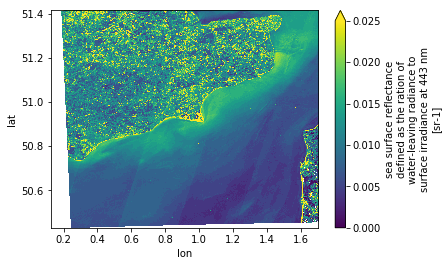

In [16]:
rrs_443_proj.plot.imshow(vmin=0., vmax=0.025)

In [17]:
subs = ds.isel(y=slice(1000, 1050), x=slice(1000, 1050))

In [18]:
subs

<xarray.Dataset>
Dimensions:                       (x: 50, y: 50)
Coordinates:
  * x                             (x) float64 3.1e+05 3.1e+05 ... 3.105e+05
  * y                             (y) float64 5.69e+06 5.69e+06 ... 5.69e+06
    lon                           (y, x) float32 ...
    lat                           (y, x) float32 ...
Data variables:
    transverse_mercator           int32 -2147483647
    rrs_443                       (y, x) float32 0.013999939 ... 0.012001038
    rrs_490                       (y, x) float32 ...
    rrs_560                       (y, x) float32 ...
    rrs_665                       (y, x) float32 ...
    rrs_705                       (y, x) float32 ...
    rrs_740                       (y, x) float32 ...
    rrs_783                       (y, x) float32 ...
    rrs_842                       (y, x) float32 ...
    rrs_865                       (y, x) float32 ...
    rrs_1610                      (y, x) float32 ...
    rrs_2190                      (y, x)

In [19]:
subs.rrs_665

<xarray.DataArray 'rrs_665' (y: 50, x: 50)>
array([[0.025002, 0.019001, 0.008999, ..., 0.005001, 0.005001, 0.004002],
       [0.028   , 0.021   , 0.009998, ..., 0.005001, 0.005001, 0.005001],
       [0.036999, 0.022999, 0.007999, ..., 0.005001, 0.005001, 0.005001],
       ...,
       [0.049999, 0.050999, 0.049999, ..., 0.013   , 0.009998, 0.007   ],
       [0.049999, 0.049   , 0.049   , ..., 0.035999, 0.028   , 0.016998],
       [0.048   , 0.047001, 0.047001, ..., 0.050999, 0.049   , 0.041   ]],
      dtype=float32)
Coordinates:
  * x        (x) float64 3.1e+05 3.1e+05 3.1e+05 ... 3.105e+05 3.105e+05
  * y        (y) float64 5.69e+06 5.69e+06 5.69e+06 ... 5.69e+06 5.69e+06
    lon      (y, x) float32 ...
    lat      (y, x) float32 ...
Attributes:
    standard_name:  surface_ratio_of_upwelling_radiance_emerging_from_sea_wat...
    long_name:      sea surface reflectance defined as the ration of water-le...
    units:          sr-1
    grid_mapping:   transverse_mercator

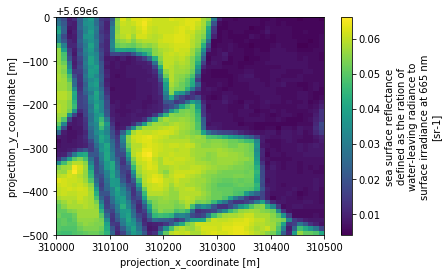

In [20]:
subs.rrs_665.plot.imshow()

In [21]:
rrs_665_proj = reproject_to_wgs84(subs.rrs_665)

src_geo_transform:  (310005.0, 10.0, 0.0, 5689505.0, 0.0, -10.0)
dst_bbox:  0.2727627754211426 51.3250617980957 0.2797878682613373 51.329463958740234
dst_size: 78 49
dst_res: 9.0065292823009e-05 8.984001315369898e-05 8.984001315369898e-05
dst_geo_transform: (0.27280769542771943, 8.984001315369898e-05, 0.0, 51.32510671810228, 0.0, -8.984001315369898e-05)


In [22]:
rrs_665_proj

<xarray.DataArray 'rrs_665' (lat: 49, lon: 78)>
array([[     nan,      nan,      nan, ..., 0.005001, 0.005001, 0.005001],
       [     nan,      nan, 0.025002, ..., 0.005001, 0.005001, 0.005001],
       [     nan,      nan,      nan, ..., 0.005001, 0.006001, 0.006001],
       ...,
       [     nan,      nan,      nan, ..., 0.015999, 0.015999, 0.028   ],
       [     nan,      nan,      nan, ..., 0.023998, 0.023998, 0.047001],
       [     nan,      nan,      nan, ..., 0.011002, 0.037998, 0.056   ]],
      dtype=float32)
Coordinates:
  * lat      (lat) float64 51.33 51.33 51.33 51.33 ... 51.33 51.33 51.33 51.32
  * lon      (lon) float64 0.2728 0.2729 0.2729 0.273 ... 0.2796 0.2797 0.2798
Attributes:
    standard_name:  surface_ratio_of_upwelling_radiance_emerging_from_sea_wat...
    long_name:      sea surface reflectance defined as the ration of water-le...
    units:          sr-1
    grid_mapping:   transverse_mercator

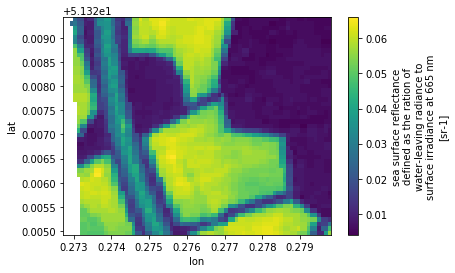

In [23]:
rrs_665_proj.plot.imshow()

In [24]:
subs = ds.isel(y=slice(1000, 1005), x=slice(1000, 1005))

In [25]:
# subs.to_netcdf("DCS4COP_S2A_0021_FLANDERS_20180802T105621Z_31UCS_V003-tiny-y1000,1005-x1000,1005.nc")

In [26]:
subs

<xarray.Dataset>
Dimensions:                       (x: 5, y: 5)
Coordinates:
  * x                             (x) float64 3.1e+05 3.1e+05 ... 3.1e+05
  * y                             (y) float64 5.69e+06 5.69e+06 ... 5.69e+06
    lon                           (y, x) float32 ...
    lat                           (y, x) float32 ...
Data variables:
    transverse_mercator           int32 -2147483647
    rrs_443                       (y, x) float32 0.013999939 ... 0.016998291
    rrs_490                       (y, x) float32 ...
    rrs_560                       (y, x) float32 ...
    rrs_665                       (y, x) float32 ...
    rrs_705                       (y, x) float32 ...
    rrs_740                       (y, x) float32 ...
    rrs_783                       (y, x) float32 ...
    rrs_842                       (y, x) float32 ...
    rrs_865                       (y, x) float32 ...
    rrs_1610                      (y, x) float32 ...
    rrs_2190                      (y, x) flo

In [27]:
subs.x

<xarray.DataArray 'x' (x: 5)>
array([310005., 310015., 310025., 310035., 310045.])
Coordinates:
  * x        (x) float64 3.1e+05 3.1e+05 3.1e+05 3.1e+05 3.1e+05
Attributes:
    units:          m
    standard_name:  projection_x_coordinate

In [28]:
subs.y

<xarray.DataArray 'y' (y: 5)>
array([5689995., 5689985., 5689975., 5689965., 5689955.])
Coordinates:
  * y        (y) float64 5.69e+06 5.69e+06 5.69e+06 5.69e+06 5.69e+06
Attributes:
    units:          m
    standard_name:  projection_y_coordinate

In [29]:
rrs_665_proj = reproject_to_wgs84(subs.rrs_665)

src_geo_transform:  (310005.0, 10.0, 0.0, 5689955.0, 0.0, -10.0)
dst_bbox:  0.2727627754211426 51.3291015625 0.273336261510849 51.329463958740234
dst_size: 6 4
dst_res: 9.558101495107015e-05 9.059906005859375e-05 9.059906005859375e-05
dst_geo_transform: (0.2728080749511719, 9.059906005859375e-05, 0.0, 51.32914686203003, 0.0, -9.059906005859375e-05)


In [30]:
rrs_665_proj

<xarray.DataArray 'rrs_665' (lat: 4, lon: 6)>
array([[0.025002, 0.019001, 0.019001, 0.008999, 0.012001, 0.012001],
       [0.028   , 0.021   , 0.021   , 0.009998, 0.009998, 0.008999],
       [0.036999, 0.022999, 0.022999, 0.007999, 0.007999, 0.008999],
       [0.041   , 0.022999, 0.022999, 0.007   , 0.007   , 0.009998]],
      dtype=float32)
Coordinates:
  * lat      (lat) float64 51.33 51.33 51.33 51.33
  * lon      (lon) float64 0.2728 0.2729 0.273 0.2731 0.2732 0.2733
Attributes:
    standard_name:  surface_ratio_of_upwelling_radiance_emerging_from_sea_wat...
    long_name:      sea surface reflectance defined as the ration of water-le...
    units:          sr-1
    grid_mapping:   transverse_mercator

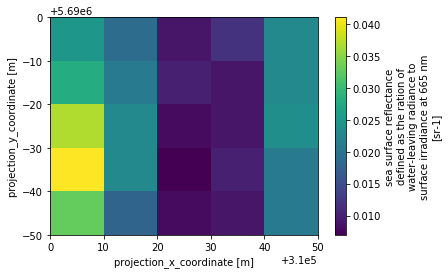

In [31]:
subs.rrs_665.plot.imshow()

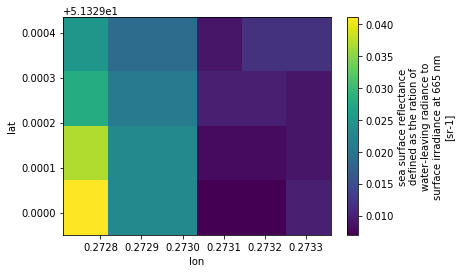

In [32]:
rrs_665_proj.plot.imshow()


In [33]:
rrs_665_proj.attrs

OrderedDict([('standard_name',
              'surface_ratio_of_upwelling_radiance_emerging_from_sea_water_to_downwelling_radiative_flux_in_air'),
             ('long_name',
              'sea surface reflectance defined as the ration of water-leaving radiance to surface irradiance at 665 nm'),
             ('units', 'sr-1'),
             ('grid_mapping', 'transverse_mercator')])

In [34]:
rrs_665_proj

<xarray.DataArray 'rrs_665' (lat: 4, lon: 6)>
array([[0.025002, 0.019001, 0.019001, 0.008999, 0.012001, 0.012001],
       [0.028   , 0.021   , 0.021   , 0.009998, 0.009998, 0.008999],
       [0.036999, 0.022999, 0.022999, 0.007999, 0.007999, 0.008999],
       [0.041   , 0.022999, 0.022999, 0.007   , 0.007   , 0.009998]],
      dtype=float32)
Coordinates:
  * lat      (lat) float64 51.33 51.33 51.33 51.33
  * lon      (lon) float64 0.2728 0.2729 0.273 0.2731 0.2732 0.2733
Attributes:
    standard_name:  surface_ratio_of_upwelling_radiance_emerging_from_sea_wat...
    long_name:      sea surface reflectance defined as the ration of water-le...
    units:          sr-1
    grid_mapping:   transverse_mercator

In [35]:
subs.rrs_665

<xarray.DataArray 'rrs_665' (y: 5, x: 5)>
array([[0.025002, 0.019001, 0.008999, 0.012001, 0.022999],
       [0.028   , 0.021   , 0.009998, 0.008999, 0.022999],
       [0.036999, 0.022999, 0.007999, 0.008999, 0.023998],
       [0.041   , 0.022999, 0.007   , 0.009998, 0.021   ],
       [0.033001, 0.018002, 0.007999, 0.008999, 0.021   ]], dtype=float32)
Coordinates:
  * x        (x) float64 3.1e+05 3.1e+05 3.1e+05 3.1e+05 3.1e+05
  * y        (y) float64 5.69e+06 5.69e+06 5.69e+06 5.69e+06 5.69e+06
    lon      (y, x) float32 ...
    lat      (y, x) float32 ...
Attributes:
    standard_name:  surface_ratio_of_upwelling_radiance_emerging_from_sea_wat...
    long_name:      sea surface reflectance defined as the ration of water-le...
    units:          sr-1
    grid_mapping:   transverse_mercator

In [40]:
subs.rrs_443

<xarray.DataArray 'rrs_443' (y: 5, x: 5)>
array([[0.014   , 0.014   , 0.016998, 0.016998, 0.016998],
       [0.014   , 0.014   , 0.016998, 0.016998, 0.016998],
       [0.019001, 0.019001, 0.016998, 0.016998, 0.016998],
       [0.019001, 0.019001, 0.016998, 0.016998, 0.016998],
       [0.019001, 0.019001, 0.016998, 0.016998, 0.016998]], dtype=float32)
Coordinates:
  * x        (x) float64 3.1e+05 3.1e+05 3.1e+05 3.1e+05 3.1e+05
  * y        (y) float64 5.69e+06 5.69e+06 5.69e+06 5.69e+06 5.69e+06
    lon      (y, x) float32 ...
    lat      (y, x) float32 ...
Attributes:
    standard_name:  surface_ratio_of_upwelling_radiance_emerging_from_sea_wat...
    long_name:      sea surface reflectance defined as the ration of water-le...
    units:          sr-1
    grid_mapping:   transverse_mercator

In [36]:
subs2 = xr.open_dataset("DCS4COP_S2A_0021_FLANDERS_20180802T105621Z_31UCS_V003-tiny-y1000,1005-x1000,1005.nc")

In [37]:
subs2.y - subs.y

<xarray.DataArray 'y' (y: 5)>
array([0., 0., 0., 0., 0.])
Coordinates:
  * y        (y) float64 5.69e+06 5.69e+06 5.69e+06 5.69e+06 5.69e+06

In [38]:
subs2.y

<xarray.DataArray 'y' (y: 5)>
array([5689995., 5689985., 5689975., 5689965., 5689955.])
Coordinates:
  * y        (y) float64 5.69e+06 5.69e+06 5.69e+06 5.69e+06 5.69e+06
Attributes:
    units:          m
    standard_name:  projection_y_coordinate